В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [504]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [505]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/11uG3Rk3uaw-RLfTY-dkWST3EdSvhpNQipIu6PylnWBM/gviz/tq?tqx=out:csv&sheet=Sheet1")
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985,Nwankwo,678,France,Male,29,4,0.00,3,1,0,180626.36,0
1,1,15650086,Ch'in,687,France,Female,34,1,0.00,2,0,1,63736.17,0
2,2,15733602,Thompson,682,France,Female,52,6,0.00,3,0,0,179655.87,1
3,3,15645794,Macleod,753,Germany,Male,44,6,83347.25,2,1,0,161407.48,0
4,4,15633840,Hsia,544,Germany,Female,55,0,107747.57,1,1,0,176580.86,1


In [506]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  int64  
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  int64  
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  int64  
 7   Tenure           15000 non-null  int64  
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  int64  
 10  HasCrCard        15000 non-null  int64  
 11  IsActiveMember   15000 non-null  int64  
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.6+ MB


In [507]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Exited"])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [508]:
input_cols = train_df.drop(columns=["Exited", "Surname"]).columns.tolist()
target_col = "Exited"

train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

Видалимо з набору інпутів колонку з прізвищем оскільки воно ніяк не має впливати на модель

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [509]:
numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_inputs.select_dtypes(exclude=[np.number]).columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [510]:
# find missing values in numeric columns
missing_numeric = train_inputs[numeric_cols].isnull().sum()
missing_valid_numeric = val_inputs[numeric_cols].isnull().sum()
# find missing values in categorical columns
missing_categorical = train_inputs[categorical_cols].isnull().sum()
missing_valid_categorical = val_inputs[categorical_cols].isnull().sum()
# print missing values
print("Missing values in numeric columns in train set:\n", missing_numeric[missing_numeric > 0])
print("\nMissing values in categorical columns in train set:\n", missing_categorical[missing_categorical > 0])
print("\nMissing values in numeric columns in validation set:\n", missing_valid_numeric[missing_valid_numeric > 0])
print("\nMissing values in categorical columns in validation set:\n", missing_valid_categorical[missing_valid_categorical > 0])

Missing values in numeric columns in train set:
 Series([], dtype: int64)

Missing values in categorical columns in train set:
 Series([], dtype: int64)

Missing values in numeric columns in validation set:
 Series([], dtype: int64)

Missing values in categorical columns in validation set:
 Series([], dtype: int64)


Як в категоріальних так і в числових колонках немає пропущених значень, отже не потрібно виконувати імпутації та заміщення

In [511]:
train_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,7479.63,15690923.99,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,4334.09,146930.97,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,3725.75,15635116.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,7471.50,15689953.00,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,11231.25,15756921.50,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [512]:
train_inputs[categorical_cols].nunique()

Geography    3
Gender       2
dtype: int64

In [513]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoder.transform(train_inputs[categorical_cols])
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
train_inputs.drop(columns=categorical_cols, inplace=True)
val_inputs.drop(columns=categorical_cols, inplace=True)

За допомогою класу OneHotEncoder ми можемо трансформувати мультикласові ознаки, оскільки географічна ознака містить 3 унікальних значення, то цей клас нам підходить

In [514]:
# Scale numeric features except id
numeric_cols.remove("id")
scaler = StandardScaler()
scaler.fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
train_inputs.head()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,7180,-0.263441,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
10393,10393,-0.666919,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
80,80,0.569420,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3365,3365,0.610162,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
12236,12236,-0.332313,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0


Ми масштабували числові ознаки, закодували категоріальні ознаки та видалили зайві колонки. Тепер ми можемо побудувати модель на всіх числових значеннях які ми маємо


Додатково проведемо аналіз кореляції даних між цільовою змінною у валідаційних даних та даних для тренування щоб визначити значення найбільш статистично значущих показників і застосувати їх в навчанні нашої моделі

In [515]:
# Find top correlated features
# add exited column to the train_inputs DataFrame for correlation analysis
train_inputs['Exited'] = train_targets
# Calculate correlation matrix and find columns with correlation > 0.05 with 'Exited'
correlation_matrix = train_inputs.corr()
corr_columns = correlation_matrix.index[abs(correlation_matrix['Exited']) > 0.05].tolist()
corr_columns.remove('Exited')


val_inputs['Exited'] = val_targets
corr_matrix_val = val_inputs.corr()
corr_columns_val = corr_matrix_val.index[abs(corr_matrix_val['Exited']) > 0.05].tolist()
corr_columns_val.remove('Exited')
# Print the correlated columns
print("Correlated columns in training set:", corr_columns)
print("Correlated columns in validation set:", corr_columns_val)

corr_columns = list(set(corr_columns + corr_columns_val))



Correlated columns in training set: ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
Correlated columns in validation set: ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [516]:
corr_columns

['EstimatedSalary',
 'Balance',
 'Geography_France',
 'Age',
 'Geography_Spain',
 'IsActiveMember',
 'CreditScore',
 'NumOfProducts',
 'Geography_Germany',
 'Gender_Female',
 'Gender_Male']

Отже в навчанні моделі будуть використовуватись лише ті колонки що мають кореляцію більшу за 0,05 та записані списком у змінну corr_columns

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [517]:
train_inputs.to_parquet("train_inputs.parquet")
val_inputs.to_parquet("val_inputs.parquet")
train_targets.to_frame().to_parquet("train_targets.parquet")
val_targets.to_frame().to_parquet("val_targets.parquet")

Перетворюємо targets на дата фрейми оскільки пандас сірієс не підтримує метод to_parquet

In [518]:
train_inputs = pd.read_parquet("train_inputs.parquet")
val_inputs = pd.read_parquet("val_inputs.parquet")
train_targets = pd.read_parquet("train_targets.parquet")[target_col]
val_targets = pd.read_parquet("val_targets.parquet")[target_col]
print("Data loaded from parquet files successfully.")
print("Train inputs shape:", train_inputs.shape)
print("Validation inputs shape:", val_inputs.shape)
print("Train targets shape:", train_targets.shape)
print("Validation targets shape:", val_targets.shape)

Data loaded from parquet files successfully.
Train inputs shape: (12000, 16)
Validation inputs shape: (3000, 16)
Train targets shape: (12000,)
Validation targets shape: (3000,)


In [519]:
os.listdir(".")

['.git',
 'HW_1_1_Основи_статистики.ipynb',
 'HW_1_2_Credit_EDA.ipynb',
 'HW_2_1_Functions_and_derivative.ipynb',
 'HW_2_1_Hypothesis_testing.ipynb',
 'HW_2_1_Linear_regression_from_many_variables.ipynb',
 'HW_2_1_Linear_regression_on_one_attribute.ipynb',
 'HW_2_1_Matrices_and_vectors.ipynb',
 'HW_2_2_Logistic_regression_with_scikit_learn.ipynb',
 'HW_2_2_Mathematical_formulation_of_logistic_regression.ipynb',
 'log_reg.joblib',
 'README.md',
 'submission_log_reg.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [520]:
X_train = train_inputs[corr_columns].values
y_train = train_targets.values
X_val = val_inputs[corr_columns].values
y_val = val_targets.values
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [521]:
def predict_and_evaluate(model, X, y, name = ''):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    print(f"F1 Score {name}:", f1)
    print(f"AUC Score {name}:", auc)
    print(f"Classification Report {name}:\n", classification_report(y, y_pred))
    print(f"Confusion Matrix {name}:\n", confusion_matrix(y, y_pred))

    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {name}')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC {name}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.show()

F1 Score Train: 0.6502904564315353
AUC Score Train: 0.8836519707517826
Classification Report Train:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      9558
           1       0.55      0.80      0.65      2442

    accuracy                           0.82     12000
   macro avg       0.74      0.82      0.77     12000
weighted avg       0.86      0.82      0.84     12000

Confusion Matrix Train:
 [[7934 1624]
 [ 483 1959]]


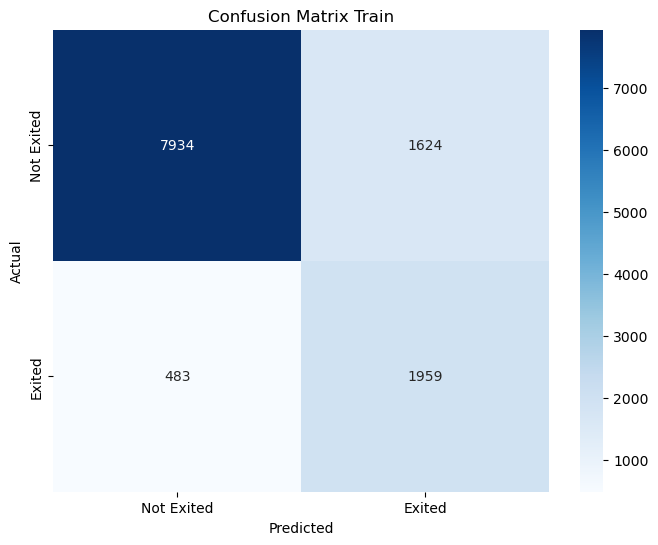

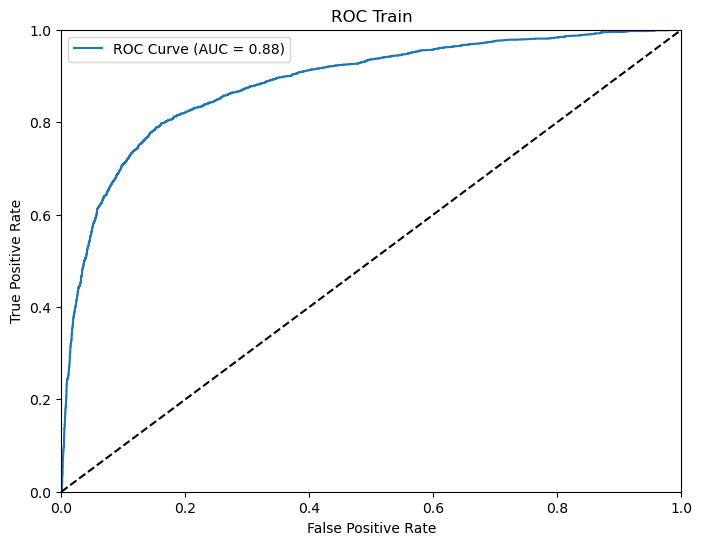

F1 Score Validation: 0.6342710997442456
AUC Score Validation: 0.8798010837506003
Classification Report Validation:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      2390
           1       0.52      0.81      0.63       610

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.82      3000

Confusion Matrix Validation:
 [[1932  458]
 [ 114  496]]


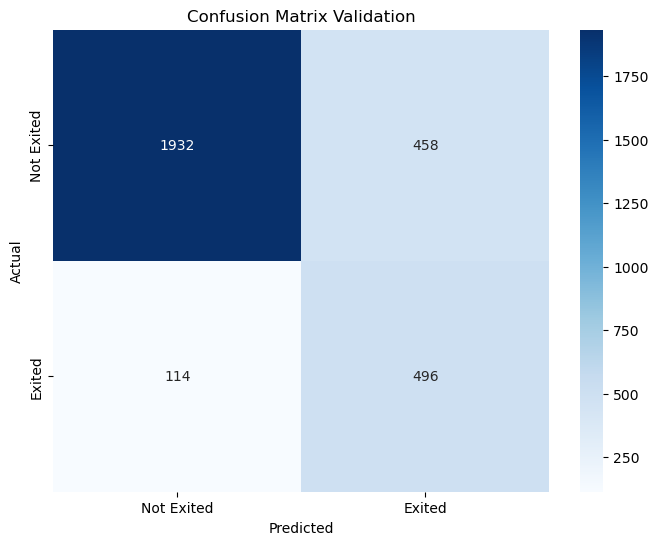

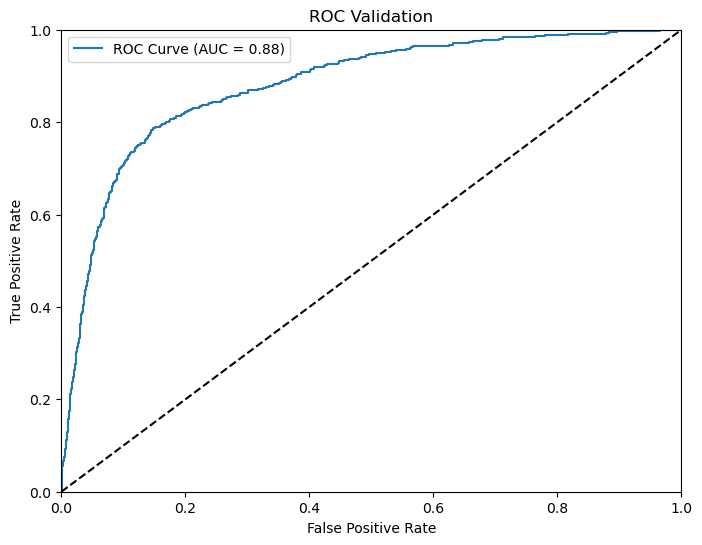

In [522]:
predict_and_evaluate(model, X_train, y_train, name='Train')
predict_and_evaluate(model, X_val, y_val, name='Validation')


Модель навчилась досить добре. Загальна точність (accuracy) — 81%, тобто в середньому вона правильно передбачає результат у 8 з 10 випадків. Для клієнтів, які залишаться (клас 0), модель працює дуже точно — точність 94% і F1-оцінка 0.87. Для клієнтів, які підуть (клас 1), модель теж показує високий recall — 81%, тобто вона виявляє більшість тих, хто піде. Її точність для класу 1 — 53%, а F1-score — 0.64, що є хорошим результатом для задач із дисбалансом класів.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [523]:
majority_class = train_targets.value_counts().idxmax()
print("Мажоритарний клас:", majority_class)
baseline_train_preds = np.full_like(train_targets, fill_value=majority_class)
baseline_val_preds = np.full_like(val_targets, fill_value=majority_class)

Мажоритарний клас: 0


In [524]:
from sklearn.metrics import accuracy_score

# Accuracy "наївної" моделі
baseline_train_acc = accuracy_score(train_targets, baseline_train_preds)
baseline_val_acc = accuracy_score(val_targets, baseline_val_preds)

# Accuracy нашої навченої моделі (з п.6)
model_train_preds = model.predict(X_train)
model_val_preds = model.predict(X_val)

model_train_acc = accuracy_score(train_targets, model_train_preds)
model_val_acc = accuracy_score(val_targets, model_val_preds)

print(f"Baseline Train Accuracy: {baseline_train_acc:.2f}")
print(f"Baseline Val Accuracy: {baseline_val_acc:.2f}")
print(f"Model Train Accuracy: {model_train_acc:.2f}")
print(f"Model Val Accuracy: {model_val_acc:.2f}")


Baseline Train Accuracy: 0.80
Baseline Val Accuracy: 0.80
Model Train Accuracy: 0.82
Model Val Accuracy: 0.81


Модель має точність ≈ 81%, але при цьому вона розпізнає більшість клієнтів, які підуть (81%) і робить це з непоганою якістю (F1 = 0.64).
Модель працює значно краще, ніж просто вгадувати більшість. ЇЇ якість хороша.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [525]:
# Save the model
import joblib
joblib.dump(model, 'log_reg.joblib')

['log_reg.joblib']

In [526]:
# Load back saved with joblib model
model_2 = joblib.load('log_reg.joblib')
model_2

LogisticRegression(class_weight='balanced', solver='liblinear')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [527]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, corr_columns, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[corr_columns]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [528]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, corr_columns, df)

array([0.02528609, 0.11437409, 0.74405318, ..., 0.97339389, 0.49905679,
       0.35619728])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [529]:
# Read test.csv file
test_raw_data = pd.read_csv("https://docs.google.com/spreadsheets/d/1oRLDSQ8Mlc0nq_mTS7ffBFWij7WMGu5lh1-5H5abBWc/gviz/tq?tqx=out:csv&sheet=Test")
# Predict probabilities for the test data and add results to the DataFrame column 'Exited'
test_raw_data['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, corr_columns, test_raw_data)
display(test_raw_data)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,-0.654266,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.0,1.0,0.0,0.0,1.0,0.224848
1,15001,-0.327399,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,1.0,0.0,0.0,0.0,1.0,0.139720
2,15002,0.172605,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,1.0,0.0,0.0,0.0,1.0,0.428261
3,15003,0.640831,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.0,0.0,1.0,0.0,1.0,0.483450
4,15004,-0.190363,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.0,0.0,1.0,0.0,1.0,0.219429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,-0.326201,Chukwumaobim,-0.274295,Spain,Male,0.038348,1.787983,-0.717950,0.769304,0.515062,1.016977,-1.499416,0.0,0.0,1.0,0.0,1.0,0.091934
9996,24996,0.329059,Clements,0.264887,Spain,Male,0.161227,1.428511,-0.717950,0.769304,0.515062,1.016977,0.537890,0.0,0.0,1.0,0.0,1.0,0.107370
9997,24997,0.447977,Chidiebere,1.592102,France,Male,-0.944682,1.428511,-0.717950,0.769304,0.515062,-0.983306,-2.481612,1.0,0.0,0.0,0.0,1.0,0.060500
9998,24998,-0.073214,Yermakova,-0.882602,France,Male,0.038348,0.350096,1.700511,-1.108193,0.515062,-0.983306,0.185943,1.0,0.0,0.0,0.0,1.0,0.405321


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [530]:
# Read sample_submission.csv file
sample_submission = pd.read_csv("https://docs.google.com/spreadsheets/d/1OuQDoTmdSp2jDaBEGLF3pOWXJvj0USSem35Elxxfg4M/gviz/tq?tqx=out:csv&sheet=SampleSubmission")
# Save the predictions to the sample_submission DataFrame by id without indexes
sample_submission['Exited'] = test_raw_data['Exited']
# Save csv file with predictions
sample_submission.to_csv("submission_log_reg.csv", index=False)